In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


a = np.array([0,2])
b = np.array([1,2])


a.tolist()

[0, 2]

In [12]:
# 回调函数测试

# 定义回调函数（业务逻辑）
def my_callback(result):
    print("接收到的数据是：", result)

# 定义一个接收回调函数的“主”函数
def fetch_data(callback):
    # 模拟获取数据的过程
    data = {"user": "Alice", "score": 95}
    # 数据准备好后，调用回调函数
    callback(data)

# 将回调函数传进去
fetch_data(my_callback)


接收到的数据是： {'user': 'Alice', 'score': 95}


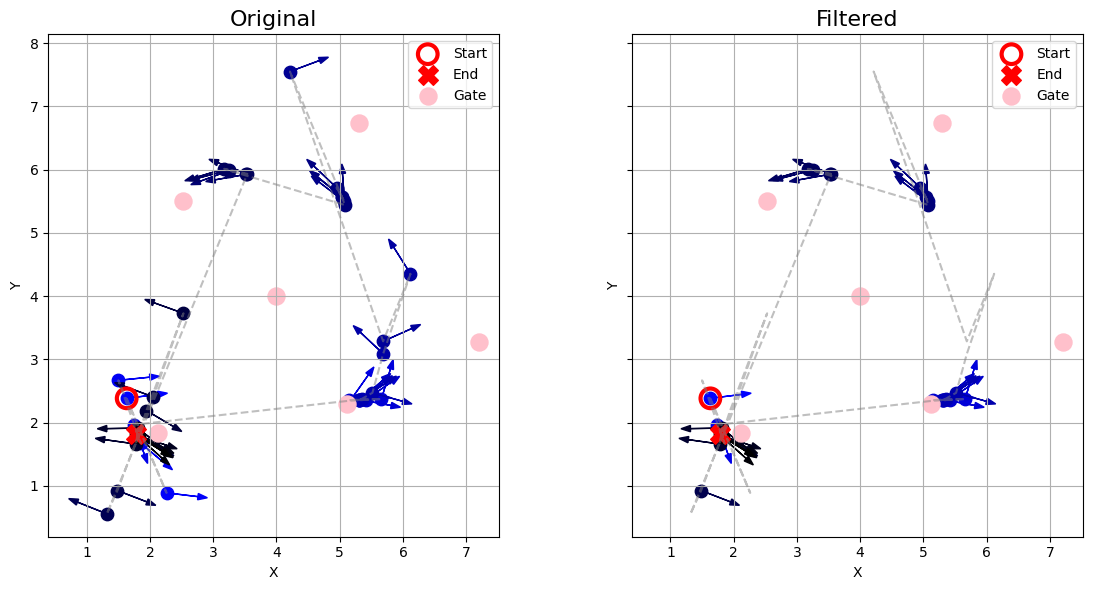

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取并筛选 P0, P3, P4
df = pd.read_csv('target_positions.csv')
df_p0 = df[df['point_index'] == 0].set_index('frame').sort_index()
df_p3 = df[df['point_index'] == 3].set_index('frame').sort_index()
df_p4 = df[df['point_index'] == 4].set_index('frame').sort_index()
frames = df_p4.index.values
points4 = df_p4[['x','y']].values
num_points = len(frames)

# 2. 距离阈值
T = 0.5

# 3. 生成 mask：第一个点默认保留，之后与前一帧 P4 距离小于阈值的保留
mask = np.zeros(num_points, dtype=bool)
mask[0] = True
for i in range(1, num_points):
    dist = np.hypot(*(points4[i] - points4[i-1]))
    if dist < T:
        mask[i] = True

# 4. 构造颜色渐变
colors_all = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]
colors_filtered = [colors_all[i] for i in range(num_points) if mask[i]]

# 粉色 Gate 点
pink_points = np.array([
    [2.12, 1.84],
    [5.12, 2.30],
    [7.20, 3.27],
    [5.30, 6.74],
    [2.52, 5.50],
    [4,4]
])

# 5. 绘图
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
titles = ['Original', 'Filtered']
L = 0.5  # 箭头长度

for ax, is_filtered, title in zip(axes, [False, True], titles):
    # 背景轨迹线（P4）
    ax.plot(df_p4['x'], df_p4['y'],
            linestyle='--', color='gray', alpha=0.5)
    
    # 散点
    if not is_filtered:
        idxs = range(num_points)
        cs = colors_all
    else:
        idxs = [i for i in range(num_points) if mask[i]]
        cs = colors_filtered
    
    for k, idx in enumerate(idxs):
        x4, y4 = points4[idx]
        ax.scatter(x4, y4, c=[cs[k]], s=80)
        
        # 计算并画箭头：取同一帧的 P0 和 P3
        frame = frames[idx]
        x0, y0 = df_p0.loc[frame, ['x','y']]
        x3, y3 = df_p3.loc[frame, ['x','y']]
        theta = np.arctan2(y0 - y3, x0 - x3) - np.pi/2
        
        # 箭头增量
        dx = L * np.cos(theta)
        dy = L * np.sin(theta)
        ax.arrow(x4, y4, dx, dy,
                 head_width=0.1, head_length=0.15,
                 fc=cs[k], ec=cs[k])

    # 起点/终点
    x_start, y_start = points4[0]
    x_end, y_end = points4[-1]
    ax.scatter(x_start, y_start,
               s=200, facecolors='none', edgecolors='red',
               marker='o', linewidths=3, label='Start')
    ax.scatter(x_end, y_end,
               s=200, color='red', marker='X',
               linewidths=1, label='End')
    
    # Gate 点
    ax.scatter(pink_points[:, 0], pink_points[:, 1],
               color='pink', marker='o', s=150, label='Gate')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


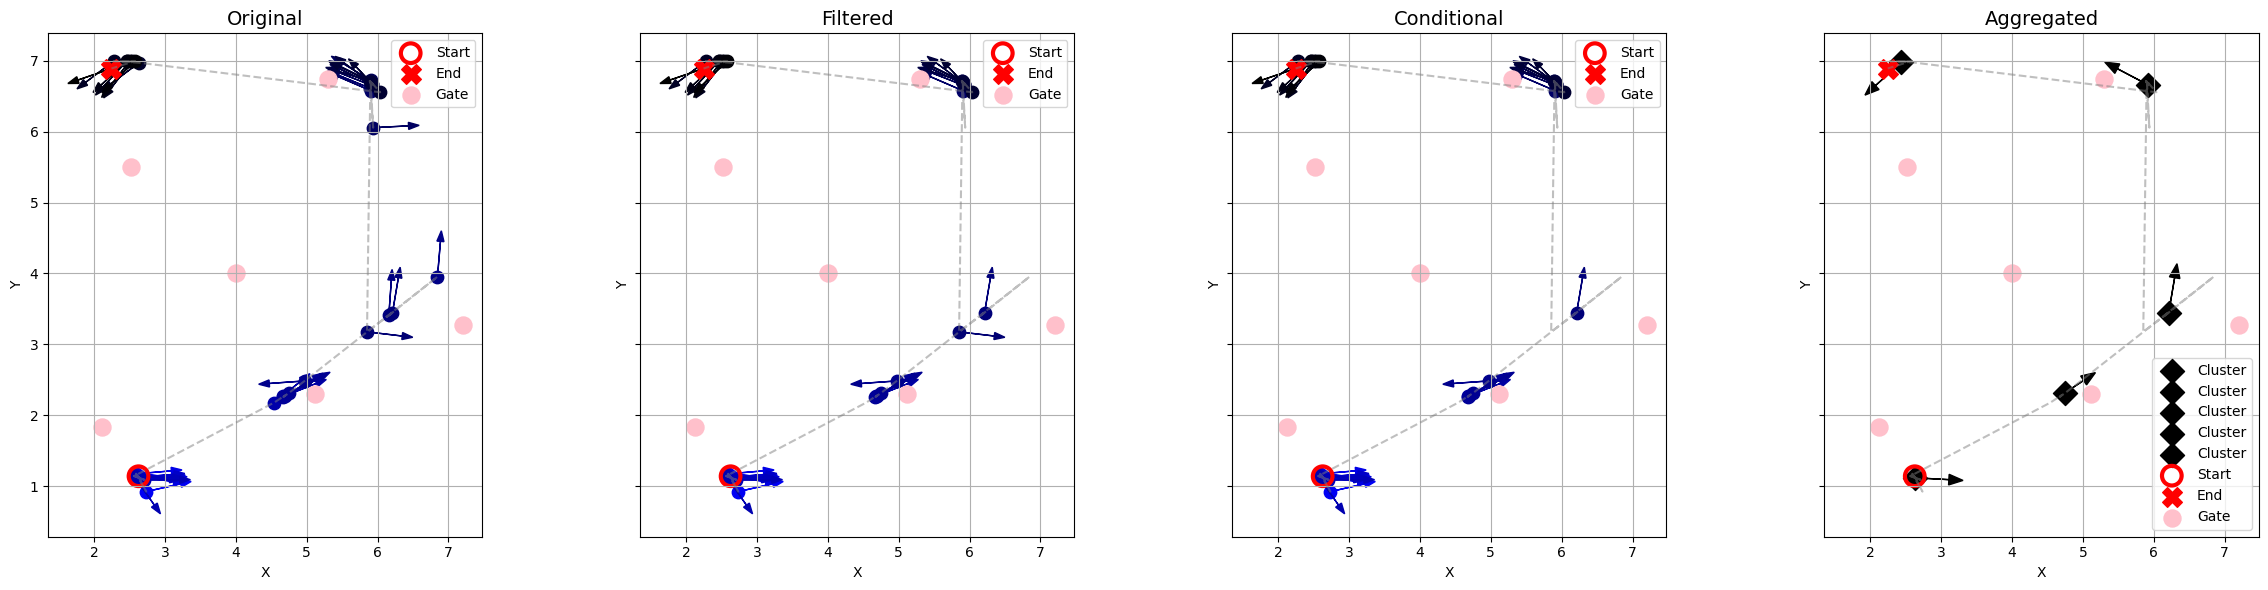

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取并筛选 P0, P3, P4
df = pd.read_csv('target_positions.csv')
df_p0 = df[df['point_index'] == 0].set_index('frame').sort_index()
df_p3 = df[df['point_index'] == 3].set_index('frame').sort_index()
df_p4 = df[df['point_index'] == 4].set_index('frame').sort_index()
frames    = df_p4.index.values
points4   = df_p4[['x','y']].values
num_points = len(frames)

# 2. 距离阈值
T = 0.5

# 3. mask：第一个点保留，其它与前一点 P4 距离 < T
mask = np.zeros(num_points, dtype=bool)
mask[0] = True
for i in range(1, num_points):
    if np.hypot(*(points4[i] - points4[i-1])) < T:
        mask[i] = True

# 4. 颜色渐变
colors_all     = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]
colors_filtered = [colors_all[i] for i in range(num_points) if mask[i]]

# Gate 点
pink_points = np.array([
    [2.12, 1.84],
    [5.12, 2.30],
    [7.20, 3.27],
    [5.30, 6.74],
    [2.52, 5.50],
    [4.00, 4.00]
])

# 5. 画 1×4 子图
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
titles = ['Original', 'Filtered', 'Conditional', 'Aggregated']
L = 0.5  # 箭头长度

# --- 先计算一下第三幅“Conditional”中被选中的索引列表，以及对应向量 2 --- #
cond_idxs = []
for i in range(num_points):
    if not mask[i]:
        continue
    # vector1: 从 Gate(4,4) 指向 P4_i
    v1 = points4[i] - np.array([4., 4.])
    # vector2: 法向量方向
    fr = frames[i]
    x0, y0 = df_p0.loc[fr, ['x','y']]
    x3, y3 = df_p3.loc[fr, ['x','y']]
    theta  = np.arctan2(y0-y3, x0-x3) - np.pi/2
    v2     = np.array([np.cos(theta), np.sin(theta)])
    # 夹角
    cos_ang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + 1e-8)
    ang_deg = np.degrees(np.arccos(np.clip(cos_ang, -1, 1)))
    if 45 <= ang_deg <= 135:
        cond_idxs.append(i)

# --- 对 cond_idxs 按前后距离 <0.8 做聚类 --- #
clusters = []
if cond_idxs:
    current = [cond_idxs[0]]
    for prev, curr in zip(cond_idxs, cond_idxs[1:]):
        if np.hypot(*(points4[curr] - points4[prev])) < 0.8:
            current.append(curr)
        else:
            clusters.append(current)
            current = [curr]
    clusters.append(current)

# --- 开始画图 --- #
for ax, title in zip(axes, titles):
    # 背景 P4 轨迹
    ax.plot(df_p4['x'], df_p4['y'],
            ls='--', color='gray', alpha=0.5)

    if title == 'Original':
        idxs, cs = range(num_points), colors_all

    elif title == 'Filtered':
        idxs, cs = [i for i in range(num_points) if mask[i]], colors_filtered

    elif title == 'Conditional':
        idxs, cs = cond_idxs, [colors_all[i] for i in cond_idxs]

    else:  # Aggregated
        # 聚类中心点 & 平均箭头
        for clust in clusters:
            pts = points4[clust]
            # 中心
            xm, ym = pts.mean(axis=0)
            # 平均箭头增量
            dxy = []
            for i in clust:
                fr = frames[i]
                x0, y0 = df_p0.loc[fr, ['x','y']]
                x3, y3 = df_p3.loc[fr, ['x','y']]
                th = np.arctan2(y0-y3, x0-x3) - np.pi/2
                dxy.append([L*np.cos(th), L*np.sin(th)])
            dx, dy = np.array(dxy).mean(axis=0)
            # 画中心点与箭头
            ax.scatter(xm, ym, s=150, marker='D', color='black', label='Cluster')
            ax.arrow(xm, ym, dx, dy,
                     head_width=0.15, head_length=0.2,
                     fc='black', ec='black')
        idxs, cs = [], []  # 不再额外画原始点

    # 如果有单点需要画，则画散点+箭头
    for k, i in enumerate(idxs):
        x4, y4 = points4[i]
        ax.scatter(x4, y4, c=[cs[k]], s=80)
        # 箭头：法向量
        fr = frames[i]
        x0, y0 = df_p0.loc[fr, ['x','y']]
        x3, y3 = df_p3.loc[fr, ['x','y']]
        th = np.arctan2(y0-y3, x0-x3) - np.pi/2
        dx, dy = L*np.cos(th), L*np.sin(th)
        ax.arrow(x4, y4, dx, dy,
                 head_width=0.1, head_length=0.15,
                 fc=cs[k], ec=cs[k])

    # 起点/终点 & Gate 点
    ax.scatter(*points4[0], s=200, facecolors='none', edgecolors='red',
               marker='o', linewidths=3, label='Start')
    ax.scatter(*points4[-1], s=200, color='red', marker='X',
               linewidths=1, label='End')
    ax.scatter(pink_points[:,0], pink_points[:,1],
               color='pink', marker='o', s=150, label='Gate')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


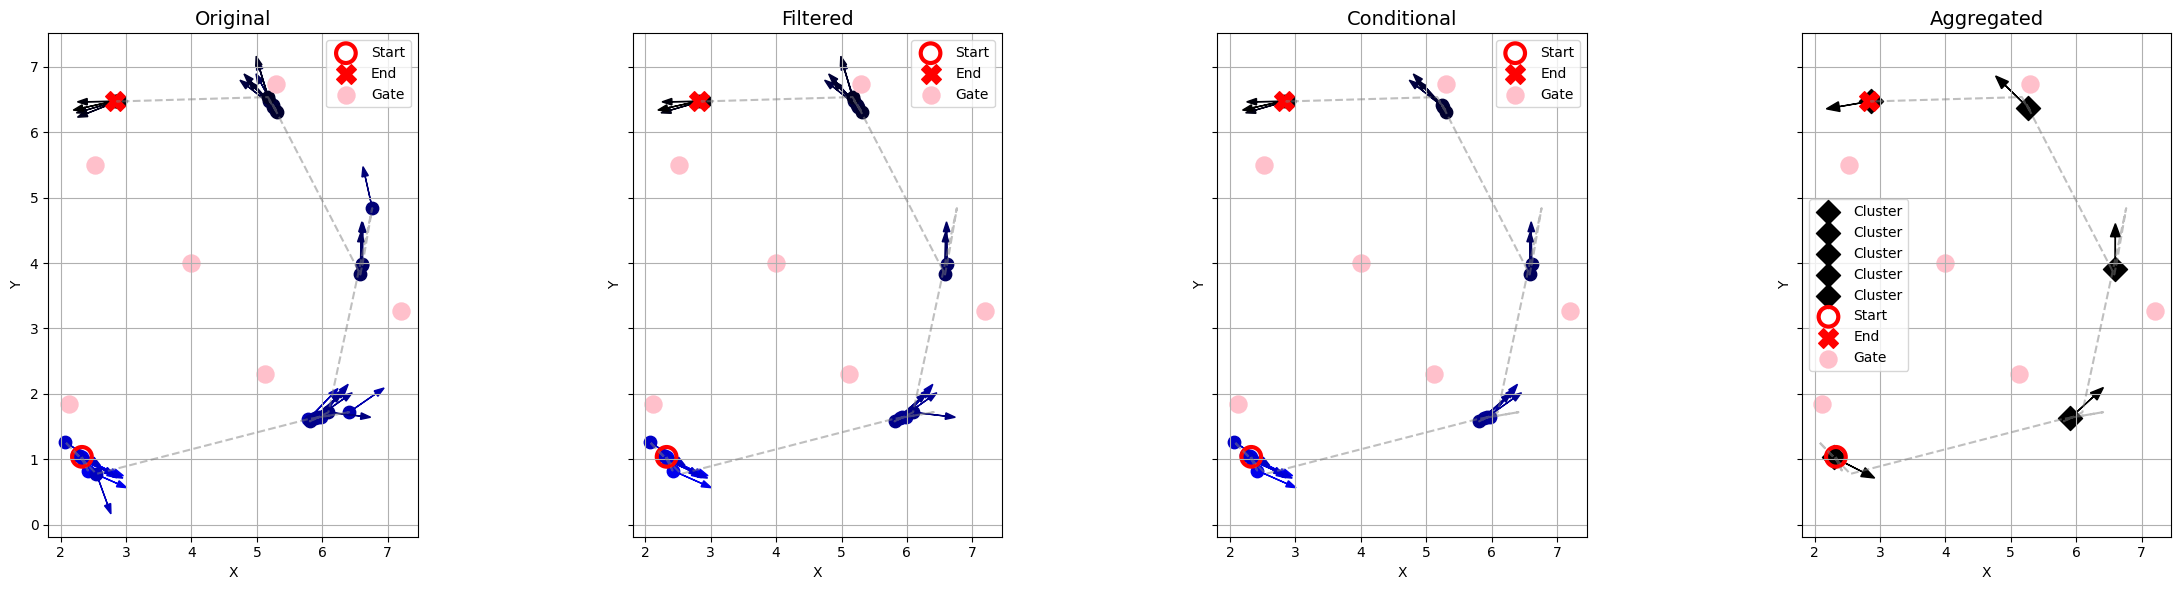

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取并筛选 P0, P3, P4
df = pd.read_csv('target_positions.csv')
df_p0 = df[df['point_index'] == 0].set_index('frame').sort_index()
df_p3 = df[df['point_index'] == 3].set_index('frame').sort_index()
df_p4 = df[df['point_index'] == 4].set_index('frame').sort_index()
frames      = df_p4.index.values
points4     = df_p4[['x','y']].values
num_points  = len(frames)

# 2. 距离阈值
T = 0.5

# 3. mask：第一个点保留，其它与前一点 P4 距离 < T
mask = np.zeros(num_points, dtype=bool)
mask[0] = True
for i in range(1, num_points):
    if np.hypot(*(points4[i] - points4[i-1])) < T:
        mask[i] = True

# 4. 颜色渐变
colors_all      = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]
colors_filtered = [colors_all[i] for i in range(num_points) if mask[i]]

# Gate 点
pink_points = np.array([
    [2.12, 1.84],
    [5.12, 2.30],
    [7.20, 3.27],
    [5.30, 6.74],
    [2.52, 5.50],
    [4.00, 4.00]
])

# 5. 画 1×4 子图
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
titles = ['Original', 'Filtered', 'Conditional', 'Aggregated']
L = 0.5  # 箭头长度

# --- 先计算一下第三幅“Conditional”中被选中的索引列表，以及对应向量 2 --- #
cond_idxs = []
for i in range(num_points):
    if not mask[i]:
        continue
    # vector1: 从 Gate(4,4) 指向 P4_i
    v1 = points4[i] - np.array([4., 4.])
    # vector2: 法向量方向
    fr = frames[i]
    x0, y0 = df_p0.loc[fr, ['x','y']]
    x3, y3 = df_p3.loc[fr, ['x','y']]
    theta   = np.arctan2(y0-y3, x0-x3) - np.pi/2
    v2      = np.array([np.cos(theta), np.sin(theta)])
    # 夹角
    cos_ang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + 1e-8)
    ang_deg = np.degrees(np.arccos(np.clip(cos_ang, -1, 1)))
    # —— 新增：将 v1, v2 补齐到 3 维 (z=0) 再叉乘 —— #
    v1_3 = np.array([v1[0], v1[1], 0.])
    v2_3 = np.array([v2[0], v2[1], 0.])
    cross_vec = np.cross(v1_3, v2_3)
    cross_z = cross_vec[2]
    # 同时满足角度在 [45,135] 且 叉积方向向上（cross_z>0）时才保留
    if 45 <= ang_deg <= 135 and cross_z > 0:
        cond_idxs.append(i)

# --- 对 cond_idxs 按前后距离 <0.8 做聚类 --- #
clusters = []
if cond_idxs:
    current = [cond_idxs[0]]
    for prev, curr in zip(cond_idxs, cond_idxs[1:]):
        if np.hypot(*(points4[curr] - points4[prev])) < 0.8:
            current.append(curr)
        else:
            clusters.append(current)
            current = [curr]
    clusters.append(current)

# --- 开始画图 --- #
for ax, title in zip(axes, titles):
    # 背景 P4 轨迹
    ax.plot(df_p4['x'], df_p4['y'],
            ls='--', color='gray', alpha=0.5)

    if title == 'Original':
        idxs, cs = range(num_points), colors_all

    elif title == 'Filtered':
        idxs, cs = [i for i in range(num_points) if mask[i]], colors_filtered

    elif title == 'Conditional':
        idxs, cs = cond_idxs, [colors_all[i] for i in cond_idxs]

    else:  # Aggregated
        # 聚类中心点 & 平均箭头
        for clust in clusters:
            pts = points4[clust]
            # 中心
            xm, ym = pts.mean(axis=0)
            # 平均箭头增量
            dxy = []
            for i in clust:
                fr = frames[i]
                x0, y0 = df_p0.loc[fr, ['x','y']]
                x3, y3 = df_p3.loc[fr, ['x','y']]
                th = np.arctan2(y0-y3, x0-x3) - np.pi/2
                dxy.append([L*np.cos(th), L*np.sin(th)])
            dx, dy = np.array(dxy).mean(axis=0)
            # 画中心点与箭头
            ax.scatter(xm, ym, s=150, marker='D', color='black', label='Cluster')
            ax.arrow(xm, ym, dx, dy,
                     head_width=0.15, head_length=0.2,
                     fc='black', ec='black')
        idxs, cs = [], []  # 不再额外画原始点

    # 如果有单点需要画，则画散点+箭头
    for k, i in enumerate(idxs):
        x4, y4 = points4[i]
        ax.scatter(x4, y4, c=[cs[k]], s=80)
        # 箭头：法向量
        fr = frames[i]
        x0, y0 = df_p0.loc[fr, ['x','y']]
        x3, y3 = df_p3.loc[fr, ['x','y']]
        th = np.arctan2(y0-y3, x0-x3) - np.pi/2
        dx, dy = L*np.cos(th), L*np.sin(th)
        ax.arrow(x4, y4, dx, dy,
                 head_width=0.1, head_length=0.15,
                 fc=cs[k], ec=cs[k])

    # 起点/终点 & Gate 点
    ax.scatter(*points4[0], s=200, facecolors='none', edgecolors='red',
               marker='o', linewidths=3, label='Start')
    ax.scatter(*points4[-1], s=200, color='red', marker='X',
               linewidths=1, label='End')
    ax.scatter(pink_points[:,0], pink_points[:,1],
               color='pink', marker='o', s=150, label='Gate')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


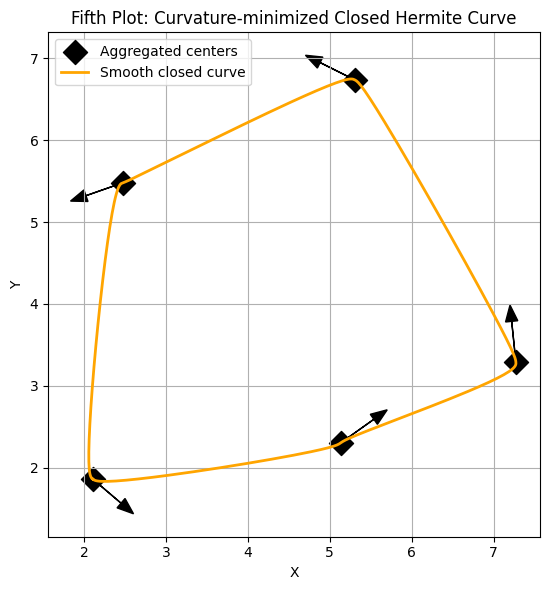

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# —— 假设已从第四幅图计算好 —— 
# cc: ndarray of shape (M,2) 聚类中心
# cd: ndarray of shape (M,2) 平均方向向量增量
cc = np.array(cluster_centers)
cd = np.array(cluster_dirs)
M  = cc.shape[0]

# 五次 Hermite 段函数：给定 Pi,Di, Pj,Dj，二阶导=0
def quintic_hermite(Pi, Di, Pj, Dj, n_samples=50):
    """
    构造 s∈[0,1] 上的五次多项式段：
      f(0)=Pi, f'(0)=Di, f''(0)=0,
      f(1)=Pj, f'(1)=Dj, f''(1)=0
    返回 n_samples 个插值点 (n_samples×2)。
    """
    E = Pj - Pi - Di        # f(1)-Pi-Di
    F = Dj - Di             # f'(1)-Di
    A =  6*E -  3*F
    B =  7*F - 15*E
    C = 10*E -  4*F
    s = np.linspace(0, 1, n_samples)[:,None]  # (n_samples,1)
    # f(s) = Pi + Di*s + C*s^3 + B*s^4 + A*s^5
    return Pi + Di*s + C*(s**3) + B*(s**4) + A*(s**5)

# 组装闭合曲线：对 i=0..M-1，段 i 从 cc[i]→cc[(i+1)%M]
curve_pts = []
n_per_seg = 50
for i in range(M):
    Pi = cc[i]
    Di = cd[i]
    j  = (i+1) % M
    Pj = cc[j]
    Dj = cd[j]
    seg = quintic_hermite(Pi, Di, Pj, Dj, n_per_seg)
    # 为了不重复端点，除最后一段外都去掉最后一点
    if i < M-1:
        seg = seg[:-1]
    curve_pts.append(seg)
curve_pts = np.vstack(curve_pts)  # (M*(n_per_seg)- (M-1), 2)

# —— 绘图 —— 
fig, ax = plt.subplots(figsize=(6,6))

# 1) 聚类中心和箭头
ax.scatter(cc[:,0], cc[:,1],
           s=150, marker='D', color='black',
           label='Aggregated centers')
for (x,y), (dx,dy) in zip(cc, cd):
    ax.arrow(x, y, dx, dy,
             head_width=0.15, head_length=0.2,
             fc='black', ec='black')

# 2) 平滑闭合曲线
ax.plot(curve_pts[:,0], curve_pts[:,1],
        '-', linewidth=2, color='orange',
        label='Smooth closed curve')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fifth Plot: Curvature‑minimized Closed Hermite Curve')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# —— 如果你已经在环境中有 pts4, df_p0, df_p3, mask, cond, clusters —— 
# —— 或者直接把 cluster_centers/cluster_dirs 赋值过来 —— 

# 假设 cc, cd 由之前步骤计算得到：
# cc = np.array(cluster_centers)
# cd = np.array(cluster_dirs)
# M  = cc.shape[0]

# 然后从第 6 步开始：
t_f = M
times = np.linspace(0, t_f, M)
disc_steps = 50

def compute_poly_matrix(self, t):
    # Inputs:
    # - t: The time of evaluation of the A matrix (t=0 at the start of a path segment, else t >= 0) [Scalar]
    # Outputs: 
    # - The constraint matrix "A_m(t)" [5 x 6]
    # The "A_m" matrix is used to represent the system of equations [x, \dot{x}, \ddot{x}, \dddot{x}, \ddddot{x}]^T  = A_m(t) * poly_coeffs (where poly_coeffs = [c_0, c_1, c_2, c_3, c_4, c_5]^T and represents the unknown polynomial coefficients for one segment)
    A_m = np.zeros((5,6))
    
    # TASK: Fill in the constraint factor matrix values where each row corresponds to the positions, velocities, accelerations, snap and jerk here
    # SOLUTION ---------------------------------------------------------------------------------- ## 
    
    A_m = np.array([
        [t**5, t**4, t**3, t**2, t, 1], #pos
        [5*(t**4), 4*(t**3), 3*(t**2), 2*t, 1, 0], #vel
        [20*(t**3), 12*(t**2), 6*t, 2, 0, 0], #acc  
        [60*(t**2), 24*t, 6, 0, 0, 0], #jerk
        [120*t, 24, 0, 0, 0, 0] #snap
    ])

    return A_m

def compute_poly_coefficients(self, path_waypoints):
    
    # Computes a minimum jerk trajectory given time and position waypoints.
    # Inputs:
    # - path_waypoints: The sequence of input path waypoints provided by the path-planner, including the start and final goal position: Vector of m waypoints, consisting of a tuple with three reference positions each as provided by AStar
    # Outputs:
    # - poly_coeffs: The polynomial coefficients for each segment of the path [6(m-1) x 3]

    # Use the following variables and the class function self.compute_poly_matrix(t) to solve for the polynomial coefficients
    
    seg_times = np.diff(self.times) #The time taken to complete each path segment
    m = len(path_waypoints) #Number of path waypoints (including start and end)
    poly_coeffs = np.zeros((6*(m-1),3))

    # YOUR SOLUTION HERE ---------------------------------------------------------------------------------- ## 

    # 1. Fill the entries of the constraint matrix A and equality vector b for x,y and z dimensions in the system A * poly_coeffs = b. Consider the constraints according to the lecture: We should have a total of 6*(m-1) constraints for each dimension.
    # 2. Solve for poly_coeffs given the defined system

    for dim in range(3):  # Compute for x, y, and z separately
        A = np.zeros((6*(m-1), 6*(m-1)))
        b = np.zeros(6*(m-1))
        pos = np.array([p[dim] for p in path_waypoints])
        A_0 = self.compute_poly_matrix(0) # A_0 gives the constraint factor matrix A_m for any segment at t=0, this is valid for the starting conditions at every path segment

        # SOLUTION
        row = 0
        for i in range(m-1):
            pos_0 = pos[i] #Starting position of the segment
            pos_f = pos[i+1] #Final position of the segment
            # The prescribed zero velocity (v) and acceleration (a) values at the start and goal position of the entire path
            v_0, a_0 = 0, 0
            v_f, a_f = 0, 0
            A_f = self.compute_poly_matrix(seg_times[i]) # A_f gives the constraint factor matrix A_m for a segment i at its relative end time t=seg_times[i]
            if i == 0: # First path segment
            #     # 1. Implement the initial constraints here for the first segment using A_0
            #     # 2. Implement the final position and the continuity constraints for velocity, acceleration, snap and jerk at the end of the first segment here using A_0 and A_f (check hints in the exercise description)
                A[row, i*6:(i+1)*6] = A_0[0] #Initial position constraint
                b[row] = pos_0
                row += 1
                A[row, i*6:(i+1)*6] = A_f[0] #Final position constraint
                b[row] = pos_f
                row += 1
                A[row, i*6:(i+1)*6] = A_0[1] #Initial velocity constraint
                b[row] = v_0
                row += 1
                A[row, i*6:(i+1)*6] = A_0[2] #Initial acceleration constraint
                b[row] = a_0
                row += 1
                #Continuity of velocity, acceleration, jerk, snap
                A[row:row+4, i*6:(i+1)*6] = A_f[1:]
                A[row:row+4, (i+1)*6:(i+2)*6] = -A_0[1:]
                b[row:row+4] = np.zeros(4)
                row += 4
            elif i < m-2: # Intermediate path segments
            #     # 1. Similarly, implement the initial and final position constraints here for each intermediate path segment
            #     # 2. Similarly, implement the end of the continuity constraints for velocity, acceleration, snap and jerk at the end of each intermediate segment here using A_0 and A_f
                A[row, i*6:(i+1)*6] = A_0[0] #Initial position constraint
                b[row] = pos_0
                row += 1
                A[row, i*6:(i+1)*6] = A_f[0] #Final position constraint
                b[row] = pos_f
                row += 1
                #Continuity of velocity, acceleration, jerk and snap
                A[row:row+4, i*6:(i+1)*6] = A_f[1:]
                A[row:row+4, (i+1)*6:(i+2)*6] = -A_0[1:]
                b[row:row+4] = np.zeros(4)
                row += 4
            elif i == m-2: #Final path segment
            #     # 1. Implement the initial and final position, velocity and accelerations constraints here for the final path segment using A_0 and A_f
                A[row, i*6:(i+1)*6] = A_0[0] #Initial position constraint
                b[row] = pos_0
                row += 1
                A[row, i*6:(i+1)*6] = A_f[0] #Final position constraint
                b[row] = pos_f
                row += 1
                A[row, i*6:(i+1)*6] = A_f[1] #Final velocity constraint
                b[row] = v_f
                row += 1
                A[row, i*6:(i+1)*6] = A_f[2] #Final acceleration constraint
                b[row] = a_f
                row += 1
        # Solve for the polynomial coefficients for the dimension dim

        poly_coeffs[:,dim] = np.linalg.solve(A, b)   

    return poly_coeffs

poly_coeffs = compute_poly_coefficients(cc, times)

# 轨迹提取
time_set = np.linspace(0, t_f, disc_steps*M)
traj = np.zeros((len(time_set),2))
for idx, t in enumerate(time_set):
    seg = min(int(np.searchsorted(times, t))-1, M-2)
    τ = t - times[seg]
    A0 = compute_poly_matrix(τ)
    coeff_x = poly_coeffs[seg*6:(seg+1)*6, 0]
    coeff_y = poly_coeffs[seg*6:(seg+1)*6, 1]
    traj[idx,0] = A0[0].dot(coeff_x)
    traj[idx,1] = A0[0].dot(coeff_y)

# 绘图
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(cc[:,0], cc[:,1], s=100, c='red', label='Waypoints')
for (x,y),(dx,dy) in zip(cc, cd):
    ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.15, fc='red', ec='red')
ax.plot(traj[:,0], traj[:,1], lw=2, label='Min-jerk Trajectory')
ax.set_aspect('equal', 'box')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('2D Motion Planning Trajectory')
ax.legend(); ax.grid(True)
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'times'

In [6]:
def set_axes_equal(ax):
    '''
    为了 3D 图等比例显示，手动把 x,y,z 的 lim 调成相同范围
    '''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]

    max_range = max(x_range, y_range, z_range)

    x_mid = np.mean(x_limits)
    y_mid = np.mean(y_limits)
    z_mid = np.mean(z_limits)

    ax.set_xlim3d(x_mid - max_range/2, x_mid + max_range/2)
    ax.set_ylim3d(y_mid - max_range/2, y_mid + max_range/2)
    ax.set_zlim3d(z_mid - max_range/2, z_mid + max_range/2)


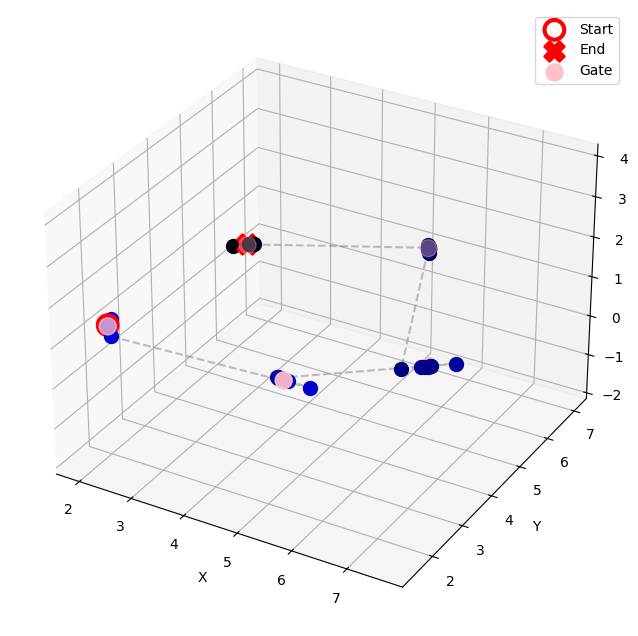

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # 导入 3D 绘图模块

# 读取 CSV 文件
df = pd.read_csv('target_positions.csv')

# 筛选 point_index 为 4 的数据，并按 frame 排序
df_center = df[df['point_index'] == 4].sort_values('frame').reset_index(drop=True)
num_points = len(df_center)

# 构造颜色列表：颜色从蓝色到黑色（RGB: (0,0,1) 到 (0,0,0)）
colors = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]

# 创建 3D 图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制连线表示轨迹（灰色虚线）
ax.plot(df_center['x'], df_center['y'], df_center['z'], linestyle='--', color='gray', alpha=0.5)

# 绘制所有点（采样点），使用渐变颜色
for idx, row in df_center.iterrows():
    color = colors[idx]
    ax.scatter(row['x'], row['y'], row['z'], color=color, s=100)

# 标注起点（第一个点，用红色圆圈标注）
start = df_center.iloc[0]
ax.scatter(start['x'], start['y'], start['z'], s=200, facecolors='none',
           edgecolors='red', marker='o', linewidths=3, label='Start')

# 标注终点（最后一个点，用红色叉号标注）
end = df_center.iloc[-1]
ax.scatter(end['x'], end['y'], end['z'], s=200, color='red', marker='X', linewidths=2, label='End')

# 用粉色标注预设的五个点
# 给定的五个点（X, Y, Z 坐标）
pink_points = np.array([
    [2.12, 1.84, 1.24],
    [5.12, 2.30, 0.78],
    [7.20, 3.27, 1.29],
    [5.30, 6.74, 1.19],
    [2.52, 5.50, 1.04]
])
# 绘制粉色点，并加上标签
ax.scatter(pink_points[:, 0], pink_points[:, 1], pink_points[:, 2], 
           color='pink', marker='o', s=150, label='Gate')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

set_axes_equal(ax)


ax.legend()
plt.show()


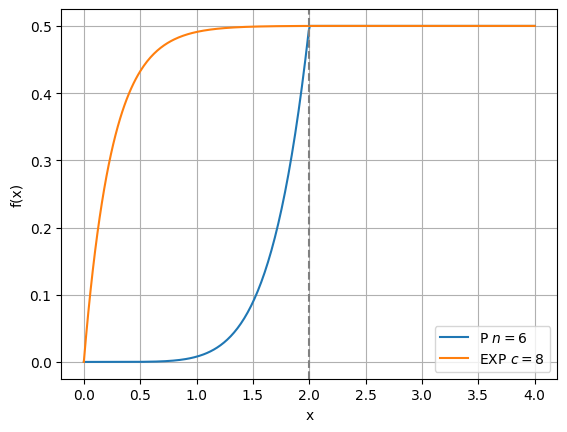

In [8]:
import numpy as np

def f_poly(x, T, n=4):
    """
    多项式型：
      x>=T    -> 0.5
      0<=x<T  -> 0.5*(x/T)^n
      x<0     -> 0
    n 越大，衰减越陡。
    """
    x = np.asarray(x, dtype=float)
    f = np.zeros_like(x)
    mask1 = x >= T
    mask2 = (x >= 0) & (x < T)
    f[mask1] = 0.5
    f[mask2] = 0.5 * (x[mask2] / T)**n
    return f

import numpy as np

def f_exp(x, T, c=5):
    """
    指数型：
      x>=T    -> 0.5
      0<=x<T  -> 0.5 * (1 - exp(-c*(x/T))) / (1 - exp(-c))
      x<0     -> 0
    c 越大，衰减越陡。
    """
    x = np.asarray(x, dtype=float)
    f = np.zeros_like(x)
    mask1 = x >= T
    mask2 = (x >= 0) & (x < T)
    f[mask1] = 0.5
    denom = 1 - np.exp(-c)
    f[mask2] = 0.5 * (1 - np.exp(-c * (x[mask2] / T))) / denom
    return f

import matplotlib.pyplot as plt

T = 2.0
xs = np.linspace(0, 4, 400)

plt.plot(xs, f_poly(xs, T, n=6),  label='P $n=6$')
plt.plot(xs, f_exp(xs, T, c=8),   label='EXP $c=8$')
plt.axvline(T, color='gray', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


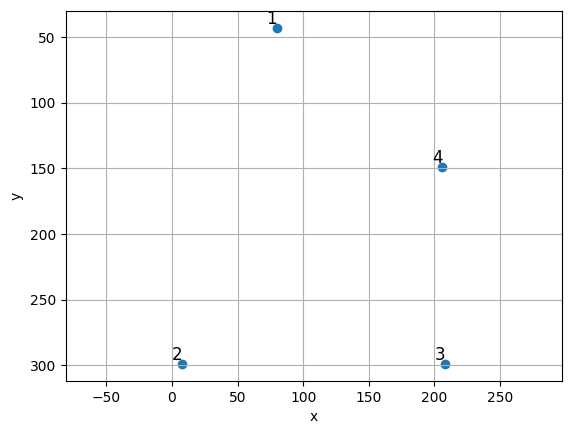

In [9]:
import numpy as np

def sort_quad_points(pts):
    """
    输入：
        pts: numpy 数组，形状 (4,2)，每行是一个 (x,y) 坐标
    返回：
        按 [左上, 左下, 右下, 右上] 排序后的点，形状 (4,2)
    """
    # 1. 按 x 坐标升序，分成左右两组
    pts_sorted = pts[np.argsort(pts[:, 0])]
    left  = pts_sorted[:2]   # x 最小的两个
    right = pts_sorted[2:]   # x 最大的两个

    # 2. 左组按 y 升序：上<下；右组同理
    left  = left[np.argsort(left[:, 1])]
    right = right[np.argsort(right[:, 1])]

    tl, bl = left    # top-left, bottom-left
    tr, br = right   # top-right, bottom-right

    return np.array([tl, bl, br, tr], dtype=pts.dtype)

def plot_quad_points(pts, sorted_pts=None):
    """
    输入：
        pts: 原始点数组，形状 (4,2)
        sorted_pts: 已排序点（可选），若不传则内部调用 sort_quad_points
    """
    if sorted_pts is None:
        sorted_pts = sort_quad_points(pts)
    
    plt.figure()
    plt.scatter(sorted_pts[:, 0], sorted_pts[:, 1])
    for i, (x, y) in enumerate(sorted_pts, start=1):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
    plt.gca().invert_yaxis()  # 图像坐标系
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.title('排序后四边形顶点及序号')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# 使用示例
pts = np.array([[80, 43],
                [8, 299],
                [208, 299],
                [206, 149]])
plot_quad_points(pts)


In [10]:
a = np.nan

a == np.nan

False